<a href="https://colab.research.google.com/github/Astra-Stark/Customer_segmentation/blob/main/CSRFM_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install chart-studio --quiet
! pip install yellowbrick --quiet

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Online Retail Data containing transactions from 01/12/2010 and 09/12/2011
path = '/content/drive/MyDrive/dataset/Online_Retail.xlsx'
Rtl_data=pd.read_excel(path)
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
Rtl_data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
82956,543277,22429,ENAMEL MEASURING JUG CREAM,2,2011-02-06 14:33:00,4.25,15808.0,United Kingdom
296658,562928,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3,2011-08-10 15:29:00,3.75,15494.0,United Kingdom
106239,545317,22385,JUMBO BAG SPACEBOY DESIGN,1,2011-03-01 14:14:00,4.13,NaN,United Kingdom
64852,541677,82482,WOODEN PICTURE FRAME WHITE FINISH,12,2011-01-20 14:01:00,2.55,12747.0,United Kingdom
299899,563179,23344,JUMBO BAG 50'S CHRISTMAS,10,2011-08-12 14:19:00,2.08,12431.0,Australia


In [ ]:
# Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(541909, 8)

In [ ]:
# Check for missing values in the dataset
Rtl_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

In [ ]:
# Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(406829, 8)

In [ ]:
# Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()

-80995

In [ ]:
# Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [ ]:
# Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [ ]:
# Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(397924, 8)

In [ ]:
# Add new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

Rtl_data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
301280,563252,22639,SET OF 4 NAPKIN CHARMS HEARTS,6,2011-08-15 11:59:00,2.55,17655.0,United Kingdom,15.30
80544,543040,84520B,PACK 20 ENGLISH ROSE PAPER NAPKINS,4,2011-02-02 17:06:00,0.85,17337.0,United Kingdom,3.40
295256,562779,84536B,FAIRY CAKES NOTEBOOK A7 SIZE,2,2011-08-09 12:58:00,0.42,17841.0,United Kingdom,0.84
324463,565401,82483,WOOD 2 DRAWER CABINET WHITE FINISH,1,2011-09-02 17:38:00,6.95,16686.0,United Kingdom,6.95
147202,549099,21166,COOK WITH WINE METAL SIGN,1,2011-04-06 11:07:00,2.08,16241.0,United Kingdom,2.08


In [ ]:
# Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(397924, 9)

In [ ]:
# Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

## RFM Modelling

In [ ]:
# Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total Amount for each customer
import datetime as dt

# Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

# Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: x.nunique(), 'TotalAmount': lambda x: x.sum()})

# Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

# Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().sample(5)

,CustomerID,Recency,Frequency,Monetary
3934,17724.0,71,3,1033.00
1062,13781.0,250,1,127.84
2299,15475.0,77,1,454.11
3336,16895.0,64,1,219.14
3083,16552.0,242,2,379.73


In [ ]:
# Check the shape (number of columns and rows) in the dataset
RFMScores.shape

(4339, 3)

In [ ]:
# Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])

quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,307.245
0.50,50.0,2.0,674.450
0.75,141.5,5.0,1661.640


In [ ]:
# Functions to create R, F and M segments
def RFMScoring(x,p,d):
    if x > d[p][0.75]:
        return 4
    elif x > d[p][0.50]:
        return 3
    elif x > d[p][0.25]:
        return 2
    else:
        return 1

In [ ]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RFMScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(RFMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(RFMScoring, args=('Monetary',quantiles,))

RFMScores.reset_index().sample(5)

,CustomerID,Recency,Frequency,Monetary,R,F,M
3857,17628.0,81,1,75.75,3,1,1
4315,18251.0,87,1,4314.72,3,1,4
1904,14952.0,59,11,8099.49,3,4,4
1067,13790.0,4,1,348.80,1,1,2
1986,15063.0,213,1,370.80,4,1,2


In [ ]:
# Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)

RFMScores.reset_index().sample(5)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore
45,12403.0,49,1,427.70,2,1,2,5
1729,14700.0,32,3,2235.30,2,3,4,9
4037,17874.0,185,6,683.46,4,4,3,11
1108,13846.0,24,3,865.06,2,3,3,8
1065,13786.0,367,1,230.40,4,1,1,6


In [ ]:
# Assign Loyalty Level to each customer
Loyalty_Level = ['Bronze', 'Silver', 'Gold', 'Platinum']
Score_cuts = pd.qcut(RFMScores.RFMScore, q=4, labels=Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values

RFMScores.reset_index().sample(5)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore,RFM_Loyalty_Level
4134,18005.0,3,2,249.72,1,2,1,4,Bronze
1744,14719.0,1,5,1602.13,1,3,3,7,Silver
425,12888.0,214,2,354.12,4,2,2,8,Gold
3,12349.0,18,1,1757.55,2,1,4,7,Silver
4316,18252.0,50,2,526.67,2,2,2,6,Bronze


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

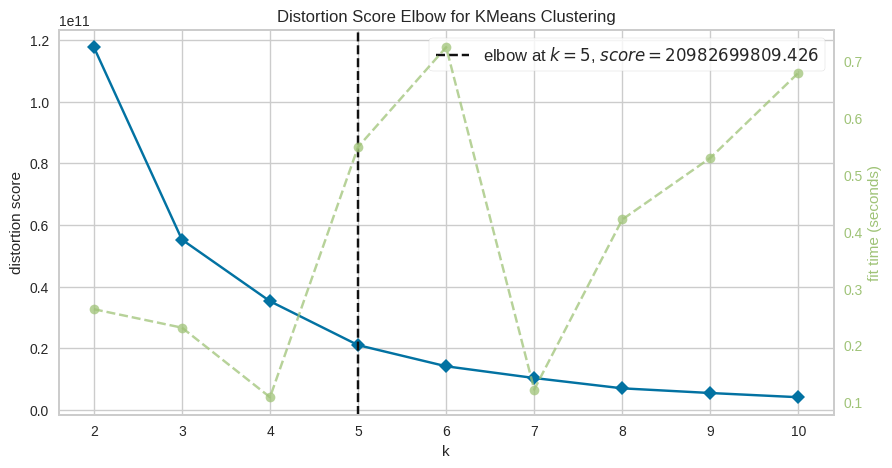

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Finding initial K value using Elbow Method
plt.figure(figsize=(10,5))
ax = plt.axes()
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(RFMScores.loc[:, RFMScores.columns != 'RFM_Loyalty_Level'])
Elbow_M.show()

In [ ]:
# Fitting KMeans Model
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(RFMScores.loc[:, RFMScores.columns != 'RFM_Loyalty_Level'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [ ]:
RFMScores["Clusters"] = kmeans.labels_
RFMScores.sample(5)

,Recency,Frequency,Monetary,R,F,M,RFMScore,RFM_Loyalty_Level,Clusters
CustomerID,,,,,,,,,
17870.0,2,12,1894.35,1,4,4,9,Gold,0
16460.0,28,3,814.72,2,3,3,8,Gold,0
14895.0,7,20,11138.71,1,4,4,9,Gold,0
15819.0,49,4,1905.45,2,3,4,9,Gold,0
14272.0,73,2,437.96,3,2,2,7,Silver,0


In [ ]:
# how well the clusters are?: centriods
kmeans.cluster_centers_

array([[9.26282260e+01, 3.89444315e+00, 1.43785600e+03, 2.50406882e+00,
        2.30667287e+00, 2.48663102e+00, 7.29737270e+00],
       [8.40000000e+00, 6.50000000e+01, 1.49828502e+05, 1.20000000e+00,
        3.60000000e+00, 4.00000000e+00, 8.80000000e+00],
       [3.00322581e+01, 4.28064516e+01, 4.63930139e+04, 1.38709677e+00,
        3.83870968e+00, 4.00000000e+00, 9.22580645e+00],
       [5.00000000e-01, 6.70000000e+01, 2.69931660e+05, 1.00000000e+00,
        4.00000000e+00, 4.00000000e+00, 9.00000000e+00]])

<function matplotlib.pyplot.show(close=None, block=None)>

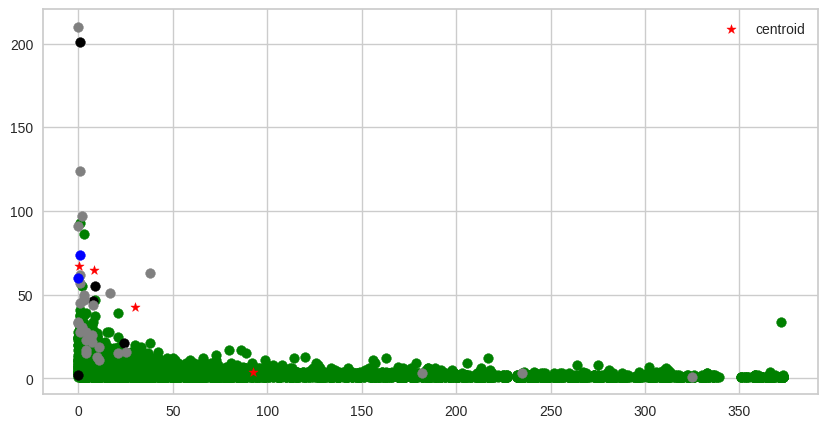

In [ ]:
# Grouping the data in accorandance with each cluster seperately
one = RFMScores[RFMScores["Clusters"]==0]
two = RFMScores[RFMScores["Clusters"]==1]
three = RFMScores[RFMScores["Clusters"]==2]
four = RFMScores[RFMScores["Clusters"]==3]
five = RFMScores[RFMScores["Clusters"]==4]

# Checking the quality of clustering in the data set
plt.figure(figsize=(10,5))
ax = plt.axes()
plt.scatter(one["Recency"],one["Frequency"],color='green')
plt.scatter(two["Recency"],two["Frequency"],color='black')
plt.scatter(three["Recency"],three["Frequency"],color='grey')
plt.scatter(four["Recency"],four["Frequency"],color='blue')
plt.scatter(five["Recency"],five["Frequency"],color='yellow')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="red",marker="*",label="centroid")
plt.legend()
plt.show

In [ ]:
max_recency = RFMScores['Recency'].max()
print("Maximum Recency:", max_recency)
max_frequency = RFMScores['Frequency'].max()
print("Maximum Frequency:", max_frequency)
max_monetary = RFMScores['Monetary'].max()
print("Maximum Monetary:", max_monetary)
max_RFMScore = RFMScores['RFMScore'].max()
print("Maximum RFMScores:", max_RFMScore)

max_cluster = RFMScores['Clusters'].max()
print("Maximum cluster:", max_cluster)


Maximum Recency: 373
Maximum Frequency: 210
Maximum Monetary: 280206.02
Maximum RFMScores: 12
Maximum cluster: 3


In [ ]:
print("Silhouette score :",silhouette_score((RFMScores.loc[:, RFMScores.columns != 'RFM_Loyalty_Level']), kmeans.labels_, metric='euclidean'))

Silhouette score : 0.954319641633133


In [ ]:
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(RFMScores.loc[:, ['Recency', 'Frequency', 'Monetary']], kmeans.labels_)
print("Davies-Bouldin Index:", davies_bouldin)



Davies-Bouldin Index: 0.36093416267648226


In [ ]:
import plotly.express as px

# Filter the data based on categories (Gold, Platinum, Bronze, Silver)
gold_data = RFMScores[RFMScores['RFM_Loyalty_Level'] == 'Gold']
platinum_data = RFMScores[RFMScores['RFM_Loyalty_Level'] == 'Platinum']
bronze_data = RFMScores[RFMScores['RFM_Loyalty_Level'] == 'Bronze']
silver_data = RFMScores[RFMScores['RFM_Loyalty_Level'] == 'Silver']

# Create a 3D scatter plot
fig = px.scatter_3d(RFMScores,
                    x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='RFM_Loyalty_Level',
                    color_discrete_map={'Gold': 'gold', 'Platinum': 'blue', 'Bronze': 'brown', 'Silver': 'silver'},
                    title='RFM Segments 3D Scatter Plot')

# Add labels to axes
fig.update_layout(scene=dict(xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary'))

# Show the plot
fig.show()


In [ ]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMScore,RFM_Loyalty_Level,Clusters
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,1,4,9,Gold,2
12347.0,2,7,4310.00,1,4,4,9,Gold,0
12348.0,75,4,1797.24,3,3,4,10,Platinum,0
12349.0,18,1,1757.55,2,1,4,7,Silver,0
12350.0,310,1,334.40,4,1,2,7,Silver,0


In [ ]:
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score

# Calculate the inertia (within-cluster sum of squares)
inertia_score = kmeans.inertia_

# Calculate the adjusted_rand_score with true labels as cluster labels
true_labels = RFMScores['Clusters']
adjusted_rand = adjusted_rand_score(true_labels, kmeans.labels_)

# Calculate the Fowlkes-Mallows score with true labels as cluster labels
fowlkes_mallows = fowlkes_mallows_score(true_labels, kmeans.labels_)

# Print the results
print("Inertia:", inertia_score)
print("Adjusted Rand Score:", adjusted_rand)
print("Fowlkes-Mallows Score:", fowlkes_mallows)

Inertia: 35223820551.01195
Adjusted Rand Score: 1.0
Fowlkes-Mallows Score: 1.0
